In [1]:
# # Install necessary libraries (Run once)
# !pip install numpy pandas spacy scikit-learn tensorflow transformers torch datasets evaluate rouge_score bert_score matplotlib seaborn
# !python -m spacy download en_core_web_sm

In [2]:
import os
import time
import re
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

# Transformers Imports
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import Dataset, DatasetDict
import evaluate

# Metrics
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings("ignore")

print(f"TensorFlow Version: {tf.__version__}")
print(f"PyTorch Version: {torch.__version__}")


TensorFlow Version: 2.16.0-rc0
PyTorch Version: 2.7.1


In [3]:
import tensorflow as tf

# Check for available devices
devices = tf.config.list_physical_devices()
print("\nDevices available:", devices)

# Check specifically for GPU/MPS
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✅ MPS/GPU detected: {gpus}")
else:
    print("\n❌ No GPU detected. Running on CPU.")


Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ MPS/GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load Data
summary = pd.read_csv('/Users/lovishbhatia/Downloads/Eco/Ankit/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/Users/lovishbhatia/Downloads/Eco/Ankit/news_summary_more.csv', encoding='iso-8859-1')

# Merge Data
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep=" "), sep=" "), sep=" "), sep=" ")

df = pd.DataFrame()
df['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
df['summary'] = pd.concat([pre1['headlines'], pre2['headlines']], ignore_index=True)

# Cleaning Function
def text_cleaner(text, remove_stopwords=False):
    # Convert to string and lowercase
    newString = str(text).lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r'"', '', newString)
    newString = re.sub(r"'s\b", "", newString)
    newString = re.sub(r"[^a-zA-Z]", " ", newString)
    newString = re.sub(r'[m]{2,}', 'mm', newString)
    
    # Optimization: Using native split/join is faster than many regexes for spaces
    tokens = [w for w in newString.split() if len(w) > 1] # Remove single chars
    return " ".join(tokens)

# Apply Cleaning
print("Cleaning Text...")
df['cleaned_text'] = df['text'].apply(text_cleaner)
print("Cleaning Summaries...")
df['cleaned_summary'] = df['summary'].apply(text_cleaner)

# Add Start/End Tokens for LSTM ONLY (Transformers don't need this manually)
df['lstm_summary'] = df['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

# Drop Empty
df.replace('', np.nan, inplace=True)
df.dropna(axis=0, inplace=True)

# Filter by Length (Crucial for LSTM stability)
max_text_len = 80
max_summary_len = 15

cleaned_text = np.array(df['cleaned_text'])
cleaned_summary = np.array(df['cleaned_summary'])
lstm_summary = np.array(df['lstm_summary'])

short_text = []
short_summary = []
short_lstm_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        short_lstm_summary.append(lstm_summary[i])
        
df_final = pd.DataFrame({'text': short_text, 'summary': short_summary, 'lstm_summary': short_lstm_summary})
print(f"Final Dataset Size: {len(df_final)}")

# Split Data
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df_final['text']),
    np.array(df_final['lstm_summary']),
    test_size=0.1,
    random_state=0,
    shuffle=True
)

# For T5, we need the raw summary (no start/end tokens)
_, _, y_tr_t5, y_val_t5 = train_test_split(
    np.array(df_final['text']),
    np.array(df_final['summary']),
    test_size=0.1,
    random_state=0,
    shuffle=True
)


Cleaning Text...
Cleaning Summaries...
Final Dataset Size: 98401


In [5]:
# --- Tokenization ---
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert to Sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Padding
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Vocab Sizes
x_voc = len(x_tokenizer.word_index) + 1
y_voc = len(y_tokenizer.word_index) + 1

# --- Model Architecture ---
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Bi-Directional LSTM (More robust than single direction)
encoder_lstm = tf.keras.layers.Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)

# Concatenate states for decoder
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# We need to double latent_dim for decoder because encoder was bidirectional
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense Output
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_lstm.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_lstm.summary()


2025-12-06 20:59:25.464079: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-06 20:59:25.464165: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-06 20:59:25.464169: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-06 20:59:25.464336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-06 20:59:25.464348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 100)   │  7,321,300 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 80, 600), │    962,400 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 300),      │            │                   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  3,137,100 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 600)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 600)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,682,400 │ embedding_1[0][0… │
│                     │ 600), (None,      │            │ concatenate[0][0… │
│                     │ 600), (None,      │            │ concatenate_1[0]… │
│                     │ 600)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 18,853,971 │ lstm_1[0][0]      │
│ (TimeDistributed)   │ 31371)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,957,171 (121.91 MB)

 Trainable params: 31,957,171 (121.91 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# --- Training ---
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history_lstm = model_lstm.fit(
    [x_tr, y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
    epochs=1, # Increase for better results
    callbacks=[es],
    batch_size=128, 
    validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:])
)


2025-12-06 20:59:26.680068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


692/692 ━━━━━━━━━━━━━━━━━━━━ 603s 867ms/step - accuracy: 0.3038 - loss: 5.9945 - val_accuracy: 0.3666 - val_loss: 5.2104


In [7]:
import accelerate
print(f"Accelerate version: {accelerate.__version__}")

Accelerate version: 1.12.0


In [8]:
# # --- Prepare Data for HuggingFace ---
# # Ensure accelerate and transformers[torch] are installed so Trainer can run without ImportError
# # (Using %pip ensures the install happens in the same Jupyter environment/kernel)
# %pip install "accelerate>=0.26.0" "transformers[torch]" -q

# Ensure raw-text splits for T5 exist (create/recreate them from df_final)
from sklearn.model_selection import train_test_split

# Recreate raw splits for T5 (these are raw text and summaries)
x_tr_t5, x_val_t5, y_tr_t5, y_val_t5 = train_test_split(
    np.array(df_final['text']),
    np.array(df_final['summary']),
    test_size=0.1,
    random_state=0,
    shuffle=True
)

# Create a small subset for demonstration (use full dataset for final experiments)
train_df = pd.DataFrame({'text': x_tr_t5[:2000], 'summary': y_tr_t5[:2000]})
val_df = pd.DataFrame({'text': x_val_t5[:500], 'summary': y_val_t5[:500]})

# Build HuggingFace datasets directly from these splits
hf_train_dataset = Dataset.from_dict({"text": train_df['text'].tolist(), "summary": train_df['summary'].tolist()})
hf_val_dataset = Dataset.from_dict({"text": val_df['text'].tolist(), "summary": val_df['summary'].tolist()})
dataset = DatasetDict({"train": hf_train_dataset, "validation": hf_val_dataset})

# --- T5 Tokenization & Setup ---
model_checkpoint = "t5-small"
tokenizer_t5 = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["text"]]
    model_inputs = tokenizer_t5(inputs, max_length=max_text_len, truncation=True)
    labels = tokenizer_t5(text_target=examples["summary"], max_length=max_summary_len, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

# --- T5 Training ---
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer_t5, model=model_t5)

# Some transformers versions don't support the 'evaluation_strategy' kwarg.
# Use do_eval=True (and optionally eval_steps) to enable evaluation instead.
args = Seq2SeqTrainingArguments(
    output_dir="./t5-news-summary",
    do_eval=True,
    # eval_steps=500,         # Uncomment and set if you want periodic evaluation
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False, # Set to True if using GPU
)

trainer = Seq2SeqTrainer(
    model=model_t5,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer_t5,
    data_collator=data_collator,
)

print("Training T5...")
trainer.train()


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Training T5...


Step,Training Loss
500,2.668100


TrainOutput(global_step=750, training_loss=2.5769539388020832, metrics={'train_runtime': 203.7701, 'train_samples_per_second': 29.445, 'train_steps_per_second': 3.681, 'total_flos': 126882938880000.0, 'train_loss': 2.5769539388020832, 'epoch': 3.0})

In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
# --- 1. Dictionaries to convert back to text ---
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# --- 2. Build Inference Models ---
# The training model is one big block. For inference, we need to break it apart.

# A. Encode the input sequence to get the feature vector
encoder_model_inf = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# B. Setup the Decoder for inference
# The decoder needs to accept the states (h and c) from the previous step
decoder_state_input_h = Input(shape=(latent_dim * 2,)) # *2 because of Bi-Directional LSTM
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2)) 

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final Decoder model
decoder_model_inf = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + [state_h2, state_c2])

# --- 3. The Decode Sequence Function ---
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model_inf.predict(input_seq, verbose=0)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['_START_']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model_inf.predict([target_seq] + [e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        # Handle cases where the index might not be in the dictionary (rare edge case)
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = "unknown"

        if(sampled_token != '_END_'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '_END_' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# --- 4. Helper to convert Integer Sequence back to Summary (Ref) ---
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i != 0 and i != target_word_index['_START_']) and i != target_word_index['_END_']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lovishbhatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lovishbhatia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lovishbhatia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluating LSTM...
Evaluating T5...
Generating summaries on cpu...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      Model   ROUGE-1   ROUGE-2   ROUGE-L  BERTScore  Latency(s)
0   Bi-LSTM  0.056593  0.000000  0.052160   0.781973    0.405129
1  T5-Small  0.322554  0.143849  0.302534   0.871127    0.146859


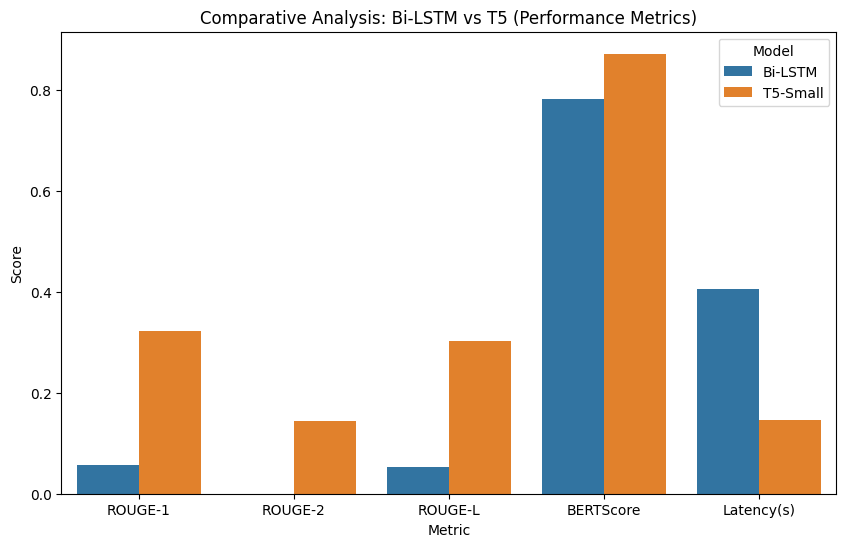

In [16]:
# Load Metrics
rouge = evaluate.load('rouge')
bertscore = evaluate.load("bertscore")
meteor = evaluate.load('meteor') # Requires NLTK download, can add if needed

# -------------------------
# LSTM Inference Utilities
# -------------------------
# Build inference encoder & decoder models from trained training-time layers.
# These layer variables (encoder_inputs, dec_emb_layer, decoder_lstm, decoder_dense,
# latent_dim, etc.) are defined in earlier cells, so reuse them here.

from tensorflow.keras import Input as KInput

# Encoder inference model: takes encoder input and returns concatenated states
# (state_h, state_c) that were created during training (state sizes are latent_dim*2).
try:
    encoder_model = Model(encoder_inputs, [state_h, state_c])
except Exception:
    # If those symbols are not in scope, raise a clear error
    raise RuntimeError("Required LSTM training objects (encoder_inputs/state_h/state_c) not found in scope.")

# Decoder inference model: single-step decoder for generating tokens one by one.
decoder_state_input_h = KInput(shape=(latent_dim * 2,))
decoder_state_input_c = KInput(shape=(latent_dim * 2,))
decoder_single_input = KInput(shape=(1,))

# Reuse the same embedding layer
dec_emb_single = dec_emb_layer(decoder_single_input)

# Run LSTM step
decoder_outputs_single, decoder_state_h_single, decoder_state_c_single = decoder_lstm(
    dec_emb_single, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Project to vocab
decoder_outputs_single = decoder_dense(decoder_outputs_single)

decoder_model = Model(
    [decoder_single_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_single, decoder_state_h_single, decoder_state_c_single]
)

# Helper to convert a sequence of token ids to a cleaned summary string
def seq2summary(seq):
    # If seq is already text, return it
    if isinstance(seq, str):
        return seq
    # If seq is a sequence of ids (padded), map to words
    words = []
    for idx in np.array(seq).astype(int).tolist():
        if idx == 0:
            continue
        w = y_tokenizer.index_word.get(idx, '')
        if not w:
            continue
        # remove start/end tokens if present
        if w.lower() in ('_start_', '_end_', '_start', '_end'):
            continue
        words.append(w)
    return " ".join(words)

# Core decode_sequence function for the trained Bi-LSTM seq2seq model
def decode_sequence(input_seq):
    """
    input_seq: numpy array shape (1, max_text_len) of token ids (padded).
    Returns: decoded summary string (without start/end tokens).
    """
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)
    # states_value is [state_h, state_c]

    # Prepare target sequence with the start token id
    start_id = None
    # try common start token text variants first
    for key in ('_start_', '_START_', '_start', '_START', 'start', '<start>', '<s>', '[START]'):
        if key in y_tokenizer.word_index:
            start_id = y_tokenizer.word_index[key]
            break

    # fallback: many tokenizers use index 2 for the <start> token (see y_tr/y_val),
    # or index 1; try to infer from tokenizer index_word if available
    if start_id is None:
        if 2 in getattr(y_tokenizer, "index_word", {}):
            start_id = 2
        elif 1 in getattr(y_tokenizer, "index_word", {}):
            start_id = 1
        else:
            # attempt to infer from a reference y_val sequence if present
            try:
                # take first non-zero token from first y_val sequence
                first_seq = np.array(y_val[0]).astype(int).tolist()
                for t in first_seq:
                    if t != 0:
                        start_id = int(t)
                        break
            except Exception:
                start_id = None

    if start_id is None:
        raise ValueError("Start token not found in y_tokenizer.word_index and could not be inferred. "
                         "Ensure your target tokenizer includes a start token or that y_val is available to infer it.")

    target_seq = np.array([[start_id]])

    stop_condition = False
    decoded_words = []
    iter_count = 0

    while not stop_condition and iter_count < max_summary_len:
        output_tokens, h, c = decoder_model.predict([target_seq, states_value[0], states_value[1]], verbose=0)
        # output_tokens shape: (1, 1, vocab_size)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = y_tokenizer.index_word.get(sampled_token_index, '')

        # If token not found or it's an end token, stop.
        if not sampled_word or sampled_word.lower() in ('_end_', '_end', 'end', '<end>', '</s>'):
            break

        decoded_words.append(sampled_word)
        # Update the target sequence (of length 1).
        target_seq = np.array([[sampled_token_index]])
        # Update states
        states_value = [h, c]
        iter_count += 1

    return " ".join(decoded_words).strip()

def generate_lstm_predictions(input_data, count=100):
    # input_data expected to be padded sequences (numpy array of shape (N, max_text_len))
    preds = []
    refs = []
    start_time = time.time()
    
    for i in range(count):
        pred = decode_sequence(input_data[i].reshape(1, max_text_len))
        preds.append(pred.replace("_START_", "").replace("_END_", "").strip())
        
        # Get Reference: handle both sequences and raw strings
        ref = seq2summary(y_val[i]) if 'y_val' in globals() else ""
        refs.append(ref.replace("_START_", "").replace("_END_", "").strip())
        
    end_time = time.time()
    return preds, refs, (end_time - start_time)/count

def generate_t5_predictions(dataset, count=100):
    # 1. Force Model to CPU to avoid the MPS Embedding Bug
    device = "cpu"
    model_t5.to(device) 
    
    inputs = dataset['text'][:count]
    refs = dataset['summary'][:count]
    preds = []
    
    start_time = time.time()
    
    print(f"Generating summaries on {device}...")
    
    for text in inputs:
        # 2. Ensure inputs are also sent to CPU
        input_ids = tokenizer_t5("summarize: " + text, return_tensors="pt").input_ids.to(device)
        
        # Generate
        outputs = model_t5.generate(input_ids, max_length=max_summary_len)
        preds.append(tokenizer_t5.decode(outputs[0], skip_special_tokens=True))
    
    end_time = time.time()
    return preds, refs, (end_time - start_time)/count

# --- Run Comparison ---
sample_size = 50 # Use 500+ for final paper

print("Evaluating LSTM...")
lstm_preds, lstm_refs, lstm_latency = generate_lstm_predictions(x_val, sample_size)

print("Evaluating T5...")
t5_preds, t5_refs, t5_latency = generate_t5_predictions(hf_val_dataset, sample_size)

# --- Compute Metrics ---
results = {'Model': [], 'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': [], 'BERTScore': [], 'Latency(s)': []}

# 1. ROUGE
lstm_rouge = rouge.compute(predictions=lstm_preds, references=lstm_refs)
t5_rouge = rouge.compute(predictions=t5_preds, references=t5_refs)

# 2. BERTScore (Semantic Similarity)
lstm_bert = bertscore.compute(predictions=lstm_preds, references=lstm_refs, lang="en")
t5_bert = bertscore.compute(predictions=t5_preds, references=t5_refs, lang="en")

# Populate Data
results['Model'] = ['Bi-LSTM', 'T5-Small']
results['ROUGE-1'] = [lstm_rouge['rouge1'], t5_rouge['rouge1']]
results['ROUGE-2'] = [lstm_rouge['rouge2'], t5_rouge['rouge2']]
results['ROUGE-L'] = [lstm_rouge['rougeL'], t5_rouge['rougeL']]
results['BERTScore'] = [np.mean(lstm_bert['f1']), np.mean(t5_bert['f1'])]
results['Latency(s)'] = [lstm_latency, t5_latency]

results_df = pd.DataFrame(results)
print(results_df)

# --- Visualization ---
# Normalize metrics for plotting
df_melt = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melt)
plt.title("Comparative Analysis: Bi-LSTM vs T5 (Performance Metrics)")
plt.show()
